<a href="https://colab.research.google.com/github/jayanth0075/Diabetes-Prediction-DSV-Project-/blob/main/diabetes86.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/keras/src/layers/regularization/gaussian_noise.py:29: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.5782 - auc: 0.6353 - loss: 21.3269 - val_accuracy: 0.7563 - val_auc: 0.8746 - val_loss: 20.3902 - learning_rate: 8.0000e-04
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7048 - auc: 0.7583 - loss: 20.1929 - val_accuracy: 0.7563 - val_auc: 0.8883 - val_loss: 19.3527 - learning_rate: 8.0000e-04
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7456 - auc: 0.8082 - loss: 19.1387 - val_accuracy: 0.7625 - val_auc: 0.8932 - val_loss: 18.3063 - learning_rate: 8.0000e-04
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7964 - auc: 0.8536 - loss: 18.0490 - val_accuracy: 0.7812 - val_auc: 0.8994 - val_loss: 17.2958 - learning_rate: 8.0000e-04
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7676 - auc: 0.8445 - loss: 17.0718 - val_accuracy: 0.8062 - val_auc: 0.9065 - val_loss: 16.3245 - learning_rate: 8.0000e-04
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/ste

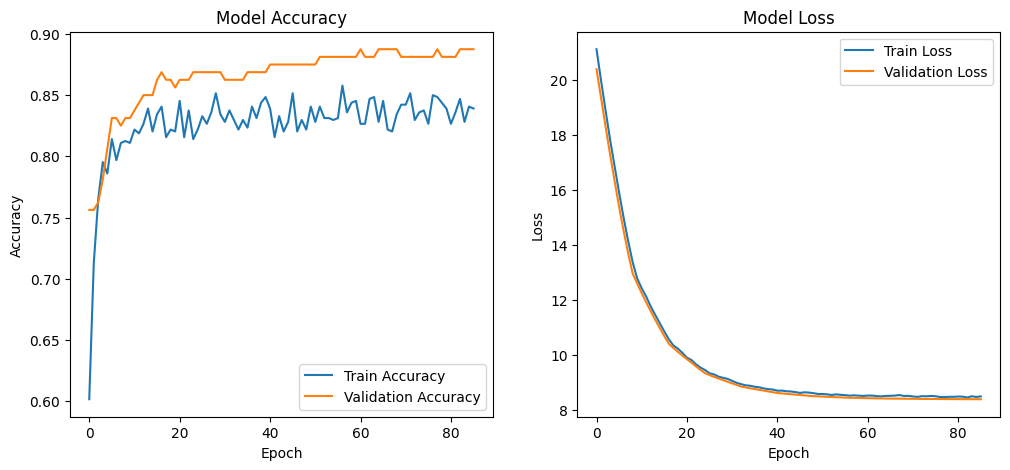

In [ ]:
!pip install tensorflow imblearn

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf # Import tensorflow here
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler # Changed to RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, make_scorer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GaussianNoise # Added GaussianNoise
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # Added ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam # Changed optimizer to Adam
from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42) # Set tensorflow seed

# Load data
file_path = '/content/drive/My Drive/diabetes.csv'  # Update with your actual path
df = pd.read_csv(file_path)

# 1. Enhanced Feature Engineering
def create_features(df):
    # Biological markers
    df['Glucose_BP_Ratio'] = df['Glucose'] / (df['BloodPressure'] + 1)
    df['Insulin_Glucose_Ratio'] = df['Insulin'] / (df['Glucose'] + 1)

    # Metabolic risk scores
    df['Metabolic_Risk'] = (df['Glucose']/100) * (df['BMI']/30) * (df['DiabetesPedigreeFunction']*10)

    # Interaction terms
    df['Age_Glucose_Interaction'] = df['Age'] * df['Glucose']
    df['BP_BMI_Interaction'] = df['BloodPressure'] * df['BMI']

    return df

df = create_features(df)

# 2. Handle Missing Values
zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[zero_cols] = df[zero_cols].replace(0, np.nan)

# Impute with median grouped by Outcome
for col in zero_cols:
    df[col] = df.groupby('Outcome')[col].transform(lambda x: x.fillna(x.median())) # Added missing parenthesis

# 3. Prepare Data
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Use RobustScaler (better for medical data)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# 4. Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# 5. Build Optimized DNN Model
model = Sequential([
    GaussianNoise(0.05, input_shape=(X_train.shape[1],)),  # Input noise for robustness

    Dense(256, activation='swish', kernel_initializer='he_normal',
          kernel_regularizer=l1_l2(l1=0.005, l2=0.005)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='swish', kernel_initializer='he_normal',
          kernel_regularizer=l1_l2(l1=0.005, l2=0.005)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='swish', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(32, activation='swish', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.1),

    Dense(1, activation='sigmoid')
])

# Custom optimizer
optimizer = Adam(learning_rate=0.0008, clipnorm=1.0)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_auc', patience=20, mode='max', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=8, min_lr=1e-6)
]

# 6. Train Model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

# 7. Evaluate Model
y_pred_prob = model.predict(X_test).flatten()

# Find optimal threshold (better than 0.5)
from sklearn.metrics import f1_score
thresholds = np.linspace(0.3, 0.7, 50)
f1_scores = [f1_score(y_test, (y_pred_prob > t).astype(int)) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]
y_pred = (y_pred_prob > best_threshold).astype(int)

# Metrics
print("\nOptimized Threshold:", best_threshold)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"\nFinal Accuracy: {accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()